# Mini-Project 2: Classification of Textual Data 

COMP 551: Applied Machine Learning 



## Task 1: Acquire, preprocess, and analyze the data

### 1.0 Resource imports, project setup

To run this code on anyone's machine, upload the data as a CSV (attached with our submission) in your personnal google drive, under a directory structure called Classes/COMP551/A1. Alternatively, replace our pd.read_csv calls with your own data import

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
import math
from scipy import sparse

#This mounts google drive
from google.colab import drive
drive.mount('/content/drive')

#This is the path to find the resource (/content/drive/My Drive/ is by default)
path='/content/drive/My Drive/Classes/COMP551/A2/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1 Loading and exploring the data

We first load the [20 news group dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) from SciKit Learn, and split it into training and testing sets. 



In [90]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=['headers', 'footers', 'quotes'])
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers', 'footers', 'quotes'])
#newsgroups_train.data = newsgroups_train.data[0:2000]
#newsgroups_test.data = newsgroups_test.data[0:2000]

We also load the Stanford [Sentiment140 dataset](http://help.sentiment140.com/for-students), and split it into training and testing sets. 

In [69]:
sentiment_train = pd.read_csv(path + 'training.1600000.processed.noemoticon.csv', 
                                 encoding='latin-1',
                                 header=None)
sentiment_test = pd.read_csv(path + 'new_testdata.manual.2009.06.14.csv', 
                             encoding='latin-1',
                             header=None)


### 1.2 Preprocessing data

In this section, we prepare the downloaded data to be used by classification models. 

#### 1.2.1 NewsGroups Dataset
First, let's work on understanding our first dataset. 

In [70]:
print(newsgroups_train.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


It looks like we have 5 keys in this dictionary. Let's explore them

In [71]:
newsgroups_train.data[:2]

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [72]:
newsgroups_train.filenames[:2]

array(['/root/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861'],
      dtype='<U86')

In [73]:
newsgroups_train.target_names[:8]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos']

In [74]:
newsgroups_train.target[:2]

array([7, 4])

In [75]:
newsgroups_train.DESCR

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n    =================   ==========\n    Classes                     20\n    Samples total           

The NewsGroups dataset contains the following keys: 

- *data* is the key that contains the instances of our dataset. Each instance is a string of text corresponding to a post on a web-forum. 

- *filenames* is a key containing the source file for the text. This is likely going to be of no use to us.

- *target_names* is a list of all the subforum titles. These are the names that give meaning to the classes we are predicting

- *target* is the label we are predicting. It is a unique number corresponding to each subforum name.

- *DESCR* is a description of the dataset.

For the purposes of this assignment, we will only need *data* and *target*. That's where all the information we need for classification purposes is contained. We convert the label sets as Numpy arrays, which are encoded as integers 0, 1, 2, etc. 

In [76]:
# Assign label sets
newsgroups_trainLabels = np.array(newsgroups_train.target)
newsgroups_testLabels = np.array(newsgroups_test.target)

In [77]:
#Implement Stemming using out of the box Porter algorithm
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
trainStemmed = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in newsgroups_train.data]
trainStemmed = [" ".join(sentence) for sentence in trainStemmed]

testStemmed = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in newsgroups_test.data]
testStemmed = [" ".join(sentence) for sentence in testStemmed]

We now convert the string features contained in both training and test sets to word count features. Each string is stripped of its accents, transformed into lower case, common English stop words are removed, then they are converted to word count features.

In [78]:
# Word count conversion
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(strip_accents='ascii',stop_words='english')
newsgroups_train_counts = count_vect.fit_transform(trainStemmed)
newsgroups_test_counts = count_vect.transform(testStemmed)

We then weight the word counts by tf-idf to put more emphasis on specific words rather than common words. 



In [79]:
# TF-IDF weighting
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
newsgroups_trainData = tfidf_transformer.fit_transform(newsgroups_train_counts)
newsgroups_testData = tfidf_transformer.transform(newsgroups_test_counts)

We then normalize the features for each column. 

In [80]:
# Normalize
#from sklearn.preprocessing import normalize
#normalize(newsgroups_trainData, norm='l1', axis=0, copy=False)
#normalize(newsgroups_testData, norm='l1', axis=0, copy=False)

#### 1.2.2 Sentiment Dataset

We now process the data from the Sentiment140 dataset. Its training set has $N=1,600,000$ instances. This is too large for Google Colab, so we need to truncate it. Here, we randomly sample a smaller portion of it. 

We also convert the label values for Sentiment140 from {0 = negative, 4 = positive} to {0 = negative, 1 = positive}. 


In [81]:
# Truncate training set by ratio
ratio = 0.1
newSize = round(ratio * sentiment_train.shape[0]) 
sentiment_trainSmall = sentiment_train.sample(newSize)

# Assign label sets, convert numerical labels
sentiment_trainLabels = np.true_divide(sentiment_trainSmall.iloc[:,0].to_numpy(),4)
sentiment_testLabels = np.true_divide(sentiment_test.iloc[:,0].to_numpy(),4)


Similarly as for the NewsGroups dataset, we convert the strings in the Sentiment140 dataset to word count features and weight by tf-idf. 

In [82]:
# Isolate strings
sentiment_train_strings = sentiment_trainSmall.iloc[:,5].to_numpy()
sentiment_test_strings = sentiment_test.iloc[:,5].to_numpy()

# Convert to word count
count_vect2 = CountVectorizer(strip_accents='ascii',stop_words='english')
sentiment_train_counts = count_vect2.fit_transform(sentiment_train_strings)
sentiment_test_counts = count_vect2.transform(sentiment_test_strings)

# Weight by tf-idf
tfidf_transformer2 = TfidfTransformer()
sentiment_trainData = tfidf_transformer2.fit_transform(sentiment_train_counts)
sentiment_testData = tfidf_transformer2.transform(sentiment_test_counts)

# Normalize 
#normalize(sentiment_trainData, norm='l1', axis=0, copy=False)
#normalize(sentiment_testData, norm='l1', axis=0, copy=False)

### 1.3 Analyzing Data

The class counts for the NewsGroups dataset are shown below.

In [83]:
label,count = np.unique(newsgroups_trainLabels,return_counts=True)
print("NewsGroups dataset")
print("Training:",dict(zip(label,count)))
print("Total training instances:",len(newsgroups_trainLabels))


NewsGroups dataset
Training: {0: 480, 1: 584, 2: 591, 3: 590, 4: 578, 5: 593, 6: 585, 7: 594, 8: 598, 9: 597, 10: 600, 11: 595, 12: 591, 13: 594, 14: 593, 15: 599, 16: 546, 17: 564, 18: 465, 19: 377}
Total training instances: 11314


In [84]:
label,count = np.unique(newsgroups_testLabels,return_counts=True)
print("NewsGroups dataset")
print("Testing:",dict(zip(label,count)))
print("Total testing instances:",len(newsgroups_testLabels))

NewsGroups dataset
Testing: {0: 319, 1: 389, 2: 394, 3: 392, 4: 385, 5: 395, 6: 390, 7: 396, 8: 398, 9: 397, 10: 399, 11: 396, 12: 393, 13: 396, 14: 394, 15: 398, 16: 364, 17: 376, 18: 310, 19: 251}
Total testing instances: 7532


Similarly, the class counts for the Sentiment140 dataset are shown below. 

In [85]:
label,count = np.unique(sentiment_trainLabels,return_counts=True)
print("Sentiment dataset")
print("Training:",dict(zip(label,count)))
print("Total training instances:",len(sentiment_trainLabels))

Sentiment dataset
Training: {0.0: 80010, 1.0: 79990}
Total training instances: 160000


In [86]:
label,count = np.unique(sentiment_testLabels,return_counts=True)
print("Sentiment dataset")
print("Testing:",dict(zip(label,count)))
print("Total testing instances:",len(sentiment_testLabels))

Sentiment dataset
Testing: {0.0: 177, 1.0: 182}
Total testing instances: 359


We check that the vocabularies are consistent (same length); as they indeed are!

In [87]:
print(newsgroups_trainData.shape)
print(newsgroups_testData.shape)

print(sentiment_trainData.shape)
print(sentiment_testData.shape)

(11314, 100169)
(7532, 100169)
(160000, 135704)
(359, 135704)


### 1.4 Dataset Class

To make our life more enjoyable, we define a Dataset class which divides each dataset into its training and testing sets. 

In [88]:
class Dataset:
    def __init__(self,trainData,trainLabels,testData,testLabels):
      self.trainData = trainData
      self.trainLabels = trainLabels
      self.testData = testData
      self.testLabels = testLabels
      return

# Instantiate NewsGroups class
NewsGroups = Dataset(newsgroups_trainData,
                     newsgroups_trainLabels,
                     newsgroups_testData,
                     newsgroups_testLabels)

# Instantiate Sentiment140 class
Sentiment140 = Dataset(sentiment_trainData,
                       sentiment_trainLabels,
                       sentiment_testData,
                       sentiment_testLabels)

## Task 2: Implement Naive Bayes and k-fold cross validation

In this section, we implement Multinomial Naive Bayes, $k$-fold cross validation and hyperparameter tuning from scratch to compare its accuracy with the logistic regression model provided by SciKit Learn. 

### 2.1 Multinomial Naive Bayes

**Training**

Let $x_d^{(n)}$ denote the number of times word $d$ appears in the $n$-th string. Let $y^{(n)}$ denote the label associated to the $n$-th string. The **Naive Bayes** model learns both the class prior $p(y)$ and class conditionals $p(x_d|y)$ from the data then uses Bayes rule to obtain the posterior class probability
$$p(y| x) \propto p(y) p(x| y).$$ 

The class *prior* is the probability of each of the $C$ classes by counting relative frequency of class labels in the dataset, which is given by the *Categorical* distribution $$p(y=c_0; \pi) = \mathrm{Categorical}(y=c_0; \pi) = \prod_{c=1}^C \pi_c^{\mathbb{I}(y=c)} = \pi_{c_0}.$$ 
The maximum likelihood estimator for $\pi$ corresponds to the frequency of class $c$ among the dataset and so is given by $$\hat{\pi}_c = \frac{N(y=c)}{N}.$$ 

The *class conditionals* represent the probability for the value of each feature $x_d$, conditioned on the class label $y$. As our features represent word counts, we use the *Multinomial* distribution: $$p(x_d| y=c; \theta) = \text{Multinomial}(x_d; \theta_y) = \frac{(\sum_{d=1}^D x_d)!}{\prod_{d=1}^D x_d !} \prod_{d=1}^D \theta_{d,y}^{x_d}.$$ 
The maximum likelihood estimator for $\theta$ is $$\hat{\theta}_{d,c}= \frac{\sum_{n} x_d^{(n)} \mathbb{I}(y^{(n)}=c)}{\sum_n \sum_{d'} x_{d'}^{(n)}\mathbb{I}(y^{(n)}=c)}$$

From the training set $\{(x^{n},y^{n})\}_{n=1}^N$, we use the above MLEs to fit the $\hat{\pi}$ and $\hat{\theta}$ parameters for the model. 

**NOTE**: The parameters $\hat{\pi}$ and $\hat{\theta}$ are computed with a Laplace smoothing parameter $\alpha\; \forall c$ as follows:
$$\hat{\pi}_c = \frac{N(y=c)+\alpha}{N+\alpha C}.$$ 

$$\hat{\theta}_{d,c} = \frac{\alpha + \sum_{n} x_d^{(n)} \mathbb{I}(y^{(n)}=c)}{\alpha D+\sum_n \sum_{d'} x_{d'}^{(n)}\mathbb{I}(y^{(n)}=c)}$$


In [91]:
class MultinomialNaiveBayes:
    # Model initialization with alpha hyperparameter
    def __init__(self,**hyperparameter):
        self.alpha = hyperparameter['alpha']
        self.theta = None
        self.pi = None
        return
        
    # Model training using training data
    def fit(self, x, y):
        N, D = x.shape            # N = num datapoints, D = num features
        C = int(np.max(y)+1)
        theta = np.zeros((C,D)) 
        Nc = np.zeros(C)
        # For each class compute MLE for theta and pi
        for c in range(C):        
            x_c = x[y == c]       # Slice all the datapoints from class c
            Nc[c] = x_c.shape[0]  # Number of datapoints with class c
            SumC = x_c.sum()      # Total number of words with class c
            theta[c] = (self.alpha + x_c.sum(0))/(self.alpha*D+SumC) 
        self.theta = theta
        self.pi = (Nc+self.alpha)/(N+self.alpha*C) 
        return self


**Class Prediction**

So far we have produced model parameters $\hat{\pi}$ and $\hat{\theta}$. To calculate the posterior for new instances, we need to evaluate
$$\tilde{p}(y=c| x) = \mathrm{Categorical}(c; \hat{\pi}) \frac{(\sum_{d=1}^D x_d)!}{\prod_{d=1}^D x_d !} \prod_{d=1}^D \hat{\theta}_{d,c}^{x_d}$$

with large number of features $D$, the product will encounter a numerical problem since it can grow too large or too small.
For this reason we work in the log domain:
\begin{align}\log \tilde{p}(y=c| x) &= \log(\hat{\pi}_c) + \log \frac{(\sum_{d=1}^D x_d)!}{\prod_{d=1}^D x_d !} + \sum_{d=1}^D  x_d \log \hat{\theta}_{d,c}\\
\end{align}

Since we later normalize the values, the middle constant term does not have to be included, because it is equal for all classes $c$ and so including it only shifts the all log-probabilities by this constant value, which is cancelled by normalization. 

**Normalization and numerical stability**

At this point we have logarithm of **unnormalized** posterior $\log \tilde{p}(y=c| x, \mathcal{D}) \; \forall c$. 
To get the probabilities, we need to normalize. We can do this in the log domain as well:
$$
\log p(y=c|x) =  (\log \tilde{p}(y=c| x)) - \log \left (\sum_{c'} \exp (\log \tilde{p}(y=c| x)) \right )
$$
Again, this could run into numerical issues because of large numbers in the exponent inside log-sum-exp. Here, we use the **log-sum-exp** trick, which uses the fact that
$
\log \sum_c \exp (z_c) = z_{\max} + \log \sum_c \exp (z_c - z_\max)
$.
In fact, one could replace $z_{max}$ with any constant. However, to help the numerical stability we use either min or max, so that all the values in the exponent are closer to zero.




In [92]:
# Helper function to compute the log-sum-exp without underflow for normalization
def logsumexp(Z): # dimension C x N
    Zmax = np.max(Z,axis=0) # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

# Predict class labels from data
def predict(self, x):
  Nt, D = x.shape 
  # Prior:  Concatenate pi Nt times --> [C x Nt] matrix
  log_prior = sparse.csr_matrix(np.repeat(np.log(self.pi)[:,np.newaxis], Nt, 1))
  # Likelihood: log(theta) * transpose(X): [C x D] * [D x Nt] = [C x Nt]
  log_likelihood = sparse.csr_matrix(np.log(self.theta)) * x.transpose()
  log_posterior = (log_prior + log_likelihood).toarray() # Posterior = prior + likelihood
  posterior = np.exp(log_posterior - logsumexp(log_posterior)) # Normalize 
  y_prob = posterior.T
  y_pred = np.argmax(y_prob,1)
  return y_pred 

MultinomialNaiveBayes.predict = predict

In our experiments, we will perform hyperparameter tuning on the Naive Bayes model with various values of the Laplace smoothing parameter $\alpha$. 

In [93]:
# Naive Bayes: Hyperparameters grid 
alpha_values = [0,0.1,0.25,0.5,0.75,1,1.5,2]
hyperparametersNB = [dict(alpha=a) for a in alpha_values]

### 2.2 Logistic Regression

We will also use the logistic regression model provided by SciKit Learn on the same datasets. In our experiments, we will vary the following hyperparameters:


- `C` $\in \{0.01,0.1,1,10,100\}$ (default = 1.0): 
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. Note that we use the default $\ell_2$ regularization in our models.

- `solver` $\in $ {`newton-cg`,`lbfgs`,`sag`,`saga`} (default = 'lbfgs'): Algorithm to use in the optimization problem. Default is ‘lbfgs’. For multiclass problems, these options are the only ones that handle multinomial loss;

The following hyperparameters will remain fixed: 

- `penalty` = `l2`: We use the $\ell_2$ norm for regularization.  
- `multi_class` = `multinomial`: The loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. 

In our experiments, we will perform hyperparameter tuning on the Logistic Regression model with all possible combinations of the `C` and `solver` hyperparameters, for fixed `penalty = 'l2'` and `multi_class='multinomial'` parameters. 


In [94]:
from sklearn.linear_model import LogisticRegression
# Hyperparameters: list of 20 different parameter combinations
solvers = ['lbfgs','saga']
Cvals = [.01,.1,1,10,100]
hyperparametersLR = [dict(multi_class='multinomial',
                          solver=s,
                          penalty='l2',
                          C=c) for s in solvers for c in Cvals]
hyperparametersLR.append(dict(multi_class='multinomial',
                          solver='lbfgs',
                          penalty='none'))
hyperparametersLR.append(dict(multi_class='multinomial',
                          solver='saga',
                          penalty='none'))

### 2.3 $k$-fold Cross Validation

Now that we have our models, we want to perform $k$-fold cross validation on each dataset for both models. We write a function `cross_validation_split` which takes an arbitrary labelled dataset and an arbitrary model with fixed hyperparameters. The following splitting function splits each dataset into $k$ equal parts. 


In [95]:
# Splitting function: Creates list of indices for K cross-validation splits

def cross_validation_split(dataset,K):
  # Create list of indices for cross validation
  N = dataset.trainData.shape[0] # Number of datapoints
  size = math.floor(N/K)  # Size of each portion
  idx = np.arange(N)      # Indices {0,1,...,N-1}
  idx = np.random.permutation(idx)  # Shuffled indices 
  validationIDX = [list(idx[i:i+size]) for i in range(0,size*K,size)]
  trainingIDX = [list(np.delete(idx,np.array(range(i,i+size)))) for i in range(0,size*K,size)]
  return trainingIDX, validationIDX


We define a helper function designed to check the accuracy given a set of predictions $\hat{y}$ and a set of true labels $y$.

In [96]:
# Accuracy function 
def evaluate_acc (y_pred, y_true):
  return np.sum(y_pred == y_true)/y_pred.shape[0]

We then construct a function `kfoldCV` that performs $k$-fold cross validation with the help of the above splitting function. Each portion is successively used as a validation set while the rest is used as a training set to fit both models. For each split, the function computes the training and validation accuracies of the arbitrary model. 

In [97]:


# K-fold Cross validation: iterates through each train/validation set 
# and returns the average result of each fold.

def kfoldCV(dataset,K,model_name,hyperparameter):
  # For each cross-validation split, train model, predict labels, report accuracy
  trainingIDX, validationIDX = cross_validation_split(dataset,K)
  training_accs = []
  validAccuracies = []
  trainAccuracies = []
  train_accs = []
  for trainIDX, validIDX in zip(trainingIDX,validationIDX):
    # Split dataset using training/validation indices
    x_train = dataset.trainData[trainIDX]
    x_validation = dataset.trainData[validIDX]
    y_train = dataset.trainLabels[trainIDX]
    y_validation = dataset.trainLabels[validIDX]

    # Train arbitrary model using training set
    model = model_name(**hyperparameter)    
    model.fit(x_train, y_train)   

    # Predict labels using validation set, record validation accuracy
    valid_pred = model.predict(x_validation)
    validAccuracies.append(evaluate_acc(y_validation,valid_pred))

    # Predict labels using training set, record training accuracy
    train_pred = model.predict(x_train)
    trainAccuracies.append(evaluate_acc(y_train,train_pred))

  return validAccuracies, trainAccuracies




### 2.4 Hyperparameter Tuning

We also construct a function `hyperparameterTuning` for automatized hyperparameter tuning, which performs $k$-fold cross validation for each set of hyperparameters, then picks the model with highest average validation accuracy. It then runs this optimal model on the test data and reports the final test accuracy. 


In [98]:
# Hyperparameter tuning function: Chooses hyperparameters with highest average
# validation accuracy and returns the test accuracy of the optimal model
# hyperparameters = list of dictionaries of hyperparameters

def hyperparameterTuning(dataset,K,model_name,hyperparameters):
  # For each hyperparameter, perform k-fold cross validation
  P = len(hyperparameters)
  validAccuracies = np.zeros((P,K))
  trainAccuracies = np.zeros((P,K))
  models = []
  for p in range(P):
    hyperparameter = hyperparameters[p]
    print("Hyperparameter:", str(hyperparameter))
    validAccuracies[p], trainAccuracies[p] = kfoldCV(dataset,K,model_name,hyperparameter)
    print('\tTrain Accuracy: ', trainAccuracies[p], 
          '\n\tValid Accuracy: ', validAccuracies[p])

  # Find model with highest average validation accuracy
  avgValAccs = np.mean(validAccuracies,1) 
  avgTrainAccs = np.mean(trainAccuracies,1)
  bestValAcc = np.argmax(avgValAccs) 
  optParameter = hyperparameters[bestValAcc]   
  optValidAccs = validAccuracies[bestValAcc]

  # Train optModel with best hyperparameters and whole training set
  optModel = model_name(**optParameter)
  optModel.fit(dataset.trainData,dataset.trainLabels)  

  # Run model on test data and compute optimal test accuracy
  test_pred = optModel.predict(dataset.testData)
  optTestAcc = evaluate_acc(test_pred,dataset.testLabels)
  
  return avgValAccs, optTestAcc, optParameter, avgTrainAccs


## Task 3: Run experiments


### 3.1 Multiclass Classification

We now conduct multi-class classification on the NewsGroups and Sentiment140 datasets using both Multinomial Naive Bayes and Logistic Regression models. We use hyperparameter tuning with 5-fold cross validation to estimate accuracy performance in all of the experiments.

#### 3.1.1 NewsGroups Classification

We first run hyperparameter tuning for the Multinomial Naive Bayes model on the NewsGroups dataset. We can visualize the average validation accuracy as a function of the hyperparameter value. 

In [99]:
# Naive Bayes
K = 5
dataset = NewsGroups
model_name = MultinomialNaiveBayes
avgValAccsNB1, optTestAccNB1, optParameterNB1, avgTrainAccsNB1 = hyperparameterTuning(
    dataset,K,model_name,hyperparametersNB)



Hyperparameter: {'alpha': 0}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.pa

	Train Accuracy:  [0.96310208 0.96354397 0.96420681 0.96288113 0.9629916 ] 
	Valid Accuracy:  [0.13439434 0.13660477 0.12024757 0.1290893  0.14323607]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.94211224 0.94277508 0.94056562 0.9402342  0.94321697] 
	Valid Accuracy:  [0.7382847  0.75906278 0.75022104 0.74137931 0.755084  ]
Hyperparameter: {'alpha': 0.25}
	Train Accuracy:  [0.91758727 0.92079099 0.92045957 0.9199072  0.92410517] 
	Valid Accuracy:  [0.72060124 0.71750663 0.72679045 0.73430592 0.72767462]
Hyperparameter: {'alpha': 0.5}
	Train Accuracy:  [0.89781264 0.90002209 0.89262042 0.9036677  0.89162616] 
	Valid Accuracy:  [0.71750663 0.70954907 0.70733864 0.73607427 0.68656057]
Hyperparameter: {'alpha': 0.75}
	Train Accuracy:  [0.88135219 0.88124171 0.8845559  0.87262483 0.88300928] 
	Valid Accuracy:  [0.70512821 0.68435013 0.70601238 0.70601238 0.70512821]
Hyperparameter: {'alpha': 1}
	Train Accuracy:  [0.86312417 0.87417145 0.86864781 0.86433937 0.86378701] 
	Valid Accurac

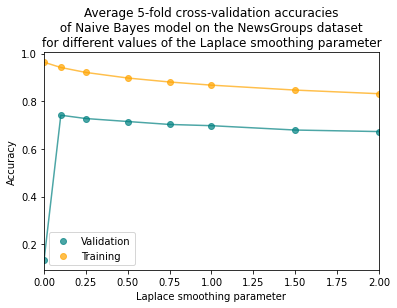

In [ ]:
# Plot average validation accuracies
plt.plot()
plt.scatter(alpha_values, avgValAccsNB1,label='Validation',c='teal',alpha=0.7)
plt.plot(alpha_values, avgValAccsNB1,'teal',alpha=0.7)
plt.scatter(alpha_values, avgTrainAccsNB1,label='Training',c='orange',alpha=0.7)
plt.plot(alpha_values, avgTrainAccsNB1,'orange',alpha=0.7)
plt.title('Average 5-fold cross-validation accuracies\n of Naive Bayes model on the NewsGroups dataset \nfor different values of the Laplace smoothing parameter')
plt.xlabel('Laplace smoothing parameter')
plt.ylabel('Accuracy')
plt.xlim(0,max(alpha_values))
plt.legend()
plt.show()

We also run hyperparameter tuning for the Logistic Regression model on the NewsGroups dataset. We can visualize the average validation accuracy as a function of the hyperparameter value. 

In [ ]:
# Logistic Regression
model_name = LogisticRegression
avgValAccsLR1, optTestAccLR1, optParameterLR1, avgTrainAccsLR1 = hyperparameterTuning(
    dataset,K,model_name,hyperparametersLR)


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
	Train Accuracy:  [0.42377375 0.52452497 0.52673442 0.57865665 0.51513478] 
	Valid Accuracy:  [0.34924845 0.42926614 0.45313882 0.49204244 0.42793988]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
	Train Accuracy:  [0.76347768 0.77286787 0.76524525 0.75695979 0.76723376] 
	Valid Accuracy:  [0.63041556 0.66578249 0.66091954 0.65384615 0.65207781]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
	Train Accuracy:  [0.92200619 0.92045957 0.91979673 0.91825011 0.91758727] 
	Valid Accuracy:  [0.72148541 0.73961096 0.72900088 0.7285588  0.73032714]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.9743703  0.97282369 0.97414936 0.97304463 0.97304463] 
	Valid Accuracy:  [0.73872679 0.74580018 0.7418214  0.74668435 0.75419982]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.973597   0.9743703  0.9743703  0.97381794 0.97425983] 
	Valid Accuracy:  [0.73916888 0.7219275  0.74624226 0.75110522 0.74801061]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
	Train Accuracy:  [0.47525409 0.47768449 0.53733981 0.53082192 0.45072912] 
	Valid Accuracy:  [0.37931034 0.38682582 0.4504863  0.46153846 0.37931034]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
	Train Accuracy:  [0.76403005 0.76513478 0.76535572 0.76723376 0.7768449 ] 
	Valid Accuracy:  [0.65517241 0.63351017 0.68169761 0.64854111 0.63748895]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 1}
	Train Accuracy:  [0.91902342 0.91813964 0.91935484 0.91968626 0.91836058] 
	Valid Accuracy:  [0.73430592 0.7382847  0.71087533 0.73474801 0.73474801]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 10}
	Train Accuracy:  [0.97425983 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


	Train Accuracy:  [0.97459125 0.97425983 0.97370747 0.97392841 0.97392841] 
	Valid Accuracy:  [0.74314766 0.7418214  0.75419982 0.74801061 0.73209549]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.9743703  0.9748122  0.97392841 0.97392841 0.97337605] 
	Valid Accuracy:  [0.72767462 0.73032714 0.73651636 0.73342175 0.72458002]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


	Train Accuracy:  [0.97470172 0.97414936 0.97459125 0.97370747 0.9731551 ] 
	Valid Accuracy:  [0.7285588  0.74447392 0.75198939 0.73386384 0.75552608]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# Plot average validation accuracies
plt.plot()
plt.rcParams["figure.figsize"] = (8,7)
plt.scatter(Cvals, avgValAccsLR1[0:5],label='Validation lbfgs L2',c='teal',alpha=0.5)
plt.plot(Cvals, avgValAccsLR1[0:5],'teal',alpha=0.5)
plt.scatter(Cvals, avgTrainAccsLR1[0:5],label='Training lbfgs L2',c='navy',alpha=0.5)
plt.plot(Cvals, avgTrainAccsLR1[0:5],'navy',alpha=0.5)

plt.scatter(Cvals, avgValAccsLR1[5:10],label='Validation saga L2',c='crimson',alpha=0.5)
plt.plot(Cvals, avgValAccsLR1[5:10],'crimson',alpha=0.5)
plt.scatter(Cvals, avgTrainAccsLR1[5:10],label='Training saga L2',c='darkred',alpha=0.5)
plt.plot(Cvals, avgTrainAccsLR1[5:10],'darkred',alpha=0.5)

plt.axhline(y=avgValAccsLR1[10],c='teal', linestyle='dashed',label='Validation lbfgs no reg.',alpha=0.5)
plt.axhline(y=avgTrainAccsLR1[10],c='navy',linestyle='dashed',label='Training lbfgs no reg.',alpha=0.5)
plt.axhline(y=avgValAccsLR1[11],c='crimson',linestyle='dashed',label='Validation saga no reg.',alpha=0.5)
plt.axhline(y=avgTrainAccsLR1[11],c='darkred',linestyle='dashed',label='Training saga no reg.',alpha=0.5)

plt.title('Average 5-fold cross-validation accuracies of\n Logistic Regression model on the NewsGroups dataset\n depending on solver and regularization strength')
plt.xlabel('Regularization constant C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()
plt.savefig(path+'NewsGroupsLR.png')

NameError: ignored

#### 3.1.2 Sentiment140 Classification

We first run hyperparameter tuning for the Multinomial Naive Bayes model on the Sentiment140 dataset. We can visualize the average validation accuracy as a function of the hyperparameter value. 

In [ ]:
# Naive Bayes
K = 5
dataset = Sentiment140
model_name = MultinomialNaiveBayes
avgValAccsNB2, optTestAccNB2, optParameterNB2, avgTrainAccsNB2 = hyperparameterTuning(dataset,K,model_name,hyperparametersNB)


Hyperparameter: {'alpha': 0}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.pa

	Train Accuracy:  [0.92050781 0.92053125 0.92023438 0.92089062 0.91978906] 
	Valid Accuracy:  [0.58659375 0.5875     0.58765625 0.58903125 0.58775   ]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.91316406 0.91322656 0.9135     0.91390625 0.913125  ] 
	Valid Accuracy:  [0.72675   0.7265625 0.7245625 0.7258125 0.7256875]
Hyperparameter: {'alpha': 0.25}
	Train Accuracy:  [0.90296875 0.90199219 0.90286719 0.90346875 0.90325   ] 
	Valid Accuracy:  [0.73409375 0.73465625 0.732625   0.7351875  0.73709375]
Hyperparameter: {'alpha': 0.5}
	Train Accuracy:  [0.88948437 0.88892187 0.88869531 0.88848437 0.88778906] 
	Valid Accuracy:  [0.73925    0.73996875 0.7405625  0.74271875 0.7459375 ]
Hyperparameter: {'alpha': 0.75}
	Train Accuracy:  [0.87742188 0.87864062 0.87689844 0.87775781 0.87716406] 
	Valid Accuracy:  [0.741      0.74321875 0.74475    0.743875   0.74653125]
Hyperparameter: {'alpha': 1}
	Train Accuracy:  [0.86871094 0.86941406 0.86842188 0.86853125 0.86988281] 
	Valid Accuracy:  [

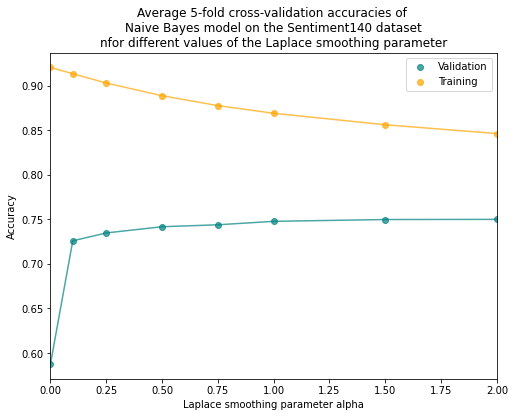

In [ ]:
# Plot average validation accuracies
plt.plot()
plt.scatter(alpha_values, avgValAccsNB2,label='Validation',c='teal',alpha=0.7)
plt.plot(alpha_values, avgValAccsNB2,'teal',alpha=0.7)
plt.scatter(alpha_values, avgTrainAccsNB2,label='Training',c='orange',alpha=0.7)
plt.plot(alpha_values, avgTrainAccsNB2,'orange',alpha=0.7)
plt.title('Average 5-fold cross-validation accuracies of \nNaive Bayes model on the Sentiment140 dataset\nnfor different values of the Laplace smoothing parameter')
plt.xlabel('Laplace smoothing parameter alpha')
plt.ylabel('Accuracy')
plt.xlim(0,max(alpha_values))
plt.legend()
plt.show()

We also run hyperparameter tuning for the Logistic Regression model on the Sentiment140 dataset. We can visualize the average validation accuracy as a function of the hyperparameter value. 

In [ ]:
# Logistic Regression
dataset = Sentiment140
model_name = LogisticRegression
avgValAccsLR2, optTestAccLR2, optParameterLR2, avgTrainAccsLR2 = hyperparameterTuning(dataset,K,model_name,hyperparametersLR)


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
	Train Accuracy:  [0.74694531 0.74689844 0.747625   0.74800781 0.74773437] 
	Valid Accuracy:  [0.7363125  0.737875   0.737      0.7356875  0.73728125]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.7865625  0.7874375  0.78578906 0.78775781 0.78615625] 
	Valid Accuracy:  [0.758      0.755875   0.7618125  0.75659375 0.76340625]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.86264063 0.86108594 0.86305469 0.86042969 0.85646094] 
	Valid Accuracy:  [0.76634375 0.76559375 0.764125   0.76353125 0.7646875 ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.93727344 0.93091406 0.9071875  0.90339844 0.9395625 ] 
	Valid Accuracy:  [0.75371875 0.748      0.750875   0.7471875  0.7479375 ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.93107031 0.90878906 0.93585938 0.94146094 0.94913281] 
	Valid Accuracy:  [0.73528125 0.734375   0.73434375 0.73303125 0.7293125 ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
	Train Accuracy:  [0.74877344 0.74748437 0.74783594 0.74604687 0.74721094] 
	Valid Accuracy:  [0.73415625 0.734      0.7364375  0.741375   0.73903125]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
	Train Accuracy:  [0.78623438 0.78598437 0.78614063 0.788      0.78614063] 
	Valid Accuracy:  [0.75875    0.760375   0.76178125 0.75465625 0.76      ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 1}
	Train Accuracy:  [0.86133594 0.86260938 0.86315625 0.86294531 0.86165625] 
	Valid Accuracy:  [0.769625   0.7631875  0.762375   0.76040625 0.76334375]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l2', 'C': 10}
	Train Accuracy:  [0.94186719 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


	Train Accuracy:  [0.95554688 0.95570312 0.95634375 0.95527344 0.95500781] 
	Valid Accuracy:  [0.7223125  0.72490625 0.7203125  0.7276875  0.7273125 ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.91196875 0.91446875 0.92304688 0.90301562 0.95185156] 
	Valid Accuracy:  [0.7310625  0.73728125 0.73203125 0.73784375 0.7154375 ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


	Train Accuracy:  [0.957625   0.95746094 0.95732031 0.95780469 0.95814062] 
	Valid Accuracy:  [0.70940625 0.712      0.712875   0.71359375 0.71184375]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


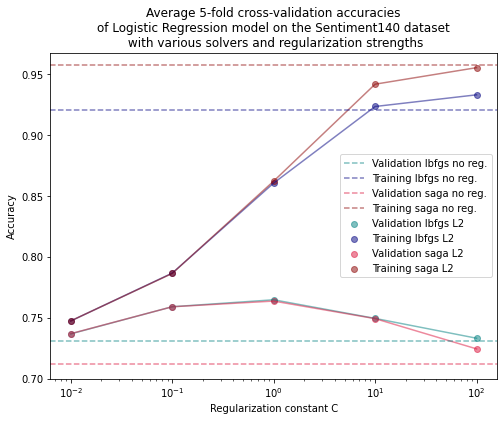

In [ ]:
# Plot average validation accuracies
plt.plot()

plt.scatter(Cvals, avgValAccsLR2[0:5],label='Validation lbfgs L2',c='teal',alpha=0.5)
plt.plot(Cvals, avgValAccsLR2[0:5],'teal',alpha=0.5)
plt.scatter(Cvals, avgTrainAccsLR2[0:5],label='Training lbfgs L2',c='navy',alpha=0.5)
plt.plot(Cvals, avgTrainAccsLR2[0:5],'navy',alpha=0.5)

plt.scatter(Cvals, avgValAccsLR2[5:10],label='Validation saga L2',c='crimson',alpha=0.5)
plt.plot(Cvals, avgValAccsLR2[5:10],'crimson',alpha=0.5)
plt.scatter(Cvals, avgTrainAccsLR2[5:10],label='Training saga L2',c='darkred',alpha=0.5)
plt.plot(Cvals, avgTrainAccsLR2[5:10],'darkred',alpha=0.5)

plt.axhline(y=avgValAccsLR2[10],c='teal', linestyle='dashed',label='Validation lbfgs no reg.',alpha=0.5)
plt.axhline(y=avgTrainAccsLR2[10],c='navy',linestyle='dashed',label='Training lbfgs no reg.',alpha=0.5)
plt.axhline(y=avgValAccsLR2[11],c='crimson',linestyle='dashed',label='Validation saga no reg.',alpha=0.5)
plt.axhline(y=avgTrainAccsLR2[11],c='darkred',linestyle='dashed',label='Training saga no reg.',alpha=0.5)

plt.title('Average 5-fold cross-validation accuracies\nof Logistic Regression model on the Sentiment140 dataset\n with various solvers and regularization strengths')
plt.xlabel('Regularization constant C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

### 3.2 Performance comparison: Naive Bayes vs Softmax Regression

We can now compare the respective test accuracies of the Naive Bayes and Logistic Regression models (with optimal hyperparameter values) on both datasets.

In [ ]:
print("NewsGroups Dataset: Test Accuracy\n\tNaive Bayes:", optTestAccNB1,
      'with parameters: ', str(optParameterNB1),
      "\n\tLogistic Regression:", optTestAccLR1,
      'with parameters: ', str(optParameterLR1))
print("Sentiment Dataset: Test Accuracy\n\tNaive Bayes:", optTestAccNB2,
      'with parameters: ', str(optParameterNB2),
      "\n\tLogistic Regression:", optTestAccLR2,
      'with parameters: ', str(optParameterLR2))

NewsGroups Dataset: Test Accuracy
	Naive Bayes: 0.6929102496016994 with parameters:  {'alpha': 0.1} 
	Logistic Regression: 0.6777748274030801 with parameters:  {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
Sentiment Dataset: Test Accuracy
	Naive Bayes: 0.7966573816155988 with parameters:  {'alpha': 2} 
	Logistic Regression: 0.7771587743732591 with parameters:  {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


### 3.3 Model Accuracy as a function of Training Size

We explore the effects of varying the size of the training ratio $q$ from 10% to 100% on the respective test accuracies of each model with the optimal hyperparameter values found previously. 

In [ ]:
# Compute test accuracy of model for each training proportion q
# NOTE: hyperparameters is a list containing a single hyperparameter dictionary 

def modelAccuracy(dataset, K, model_name, hyperparameters, qValues):
  testAccuracies = []
  N = dataset.trainData.shape[0]
  for q in qValues:
    # Randomly pick p% of entire training set
    size = math.ceil(N*q)   
    idx = random.sample(range(0, N), size)
    smallDataset = Dataset(dataset.trainData[idx],
                       dataset.trainLabels[idx],
                       dataset.testData,
                       dataset.testLabels)
    # Record test accuracy 
    avgValAccs, optTestAcc, optParameter, avgTrainAccs = hyperparameterTuning(
        smallDataset,K,model_name,hyperparameters)
    testAccuracies.append(optTestAcc)
  return testAccuracies


In [ ]:
# Define different training ratios q = 10%, 20%, ..., 100%
qValues = np.linspace(0.1,1,10)  

# Newsgroups NB
model_name = MultinomialNaiveBayes
hyperparameters = [optParameterNB1]
testAccuraciesNB1 = modelAccuracy(NewsGroups,K,model_name,hyperparameters,qValues)


Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.96799117 0.96909492 0.98233996 0.96799117 0.97019868] 
	Valid Accuracy:  [0.54424779 0.54867257 0.55752212 0.53982301 0.51327434]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.9591386  0.95858642 0.96024296 0.96300387 0.96300387] 
	Valid Accuracy:  [0.61946903 0.64159292 0.62389381 0.62389381 0.59955752]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.95876289 0.96207658 0.96391753 0.95913108 0.96207658] 
	Valid Accuracy:  [0.66715758 0.65832106 0.64359352 0.62150221 0.65684831]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.95747031 0.95912731 0.96106048 0.95526098 0.95995581] 
	Valid Accuracy:  [0.68618785 0.67734807 0.67734807 0.6839779  0.65966851]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.96000884 0.95912506 0.95581087 0.95271763 0.9569156 ] 
	Valid Accuracy:  [0.69849691 0.69053935 0.69496021 0.71264368 0.69142352]
Hyperparameter: {'alpha': 0.1}
	Train Accuracy:  [0.94918999 0.9519514  0.95121502 0.95324

In [ ]:
# Newsgroups LR
model_name = LogisticRegression
hyperparameters = [optParameterLR1]
testAccuraciesLR1 = modelAccuracy(NewsGroups,K,model_name,hyperparameters,qValues)

Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
	Train Accuracy:  [0.97792494 0.97461369 0.97682119 0.97240618 0.97130243] 
	Valid Accuracy:  [0.5840708  0.55752212 0.57079646 0.59734513 0.56637168]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


	Train Accuracy:  [0.97404749 0.97736057 0.97570403 0.97736057 0.97404749] 
	Valid Accuracy:  [0.61061947 0.59734513 0.67256637 0.61946903 0.63053097]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.9775405  0.97606775 0.97606775 0.97717231 0.97606775] 
	Valid Accuracy:  [0.64801178 0.69072165 0.69072165 0.65832106 0.67157585]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97431649 0.97404032 0.97017399 0.97459265 0.97459265] 
	Valid Accuracy:  [0.70165746 0.71712707 0.7160221  0.69060773 0.70055249]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97414936 0.97569598 0.97326558 0.97613787 0.97459125] 
	Valid Accuracy:  [0.71441202 0.68965517 0.72236958 0.70645447 0.71352785]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97330633 0.97404271 0.97643594 0.97533137 0.97459499] 
	Valid Accuracy:  [0.71186441 0.73544584 0.72439204 0.70596905 0.71997052]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97332702 0.97285354 0.97301136 0.97332702 0.97301136] 
	Valid Accuracy:  [0.72348485 0.73863636 0.71401515 0.73358586 0.71527778]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97362607 0.97390224 0.97265949 0.9741784  0.97376415] 
	Valid Accuracy:  [0.74751381 0.72375691 0.71878453 0.73314917 0.74033149]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97275071 0.97385541 0.97422364 0.97397815 0.97446913] 
	Valid Accuracy:  [0.73084479 0.73870334 0.74607073 0.73821218 0.73428291]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.97381794 0.9743703  0.97414936 0.97205038 0.97271321] 
	Valid Accuracy:  [0.73916888 0.755084   0.74403183 0.74580018 0.74535809]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


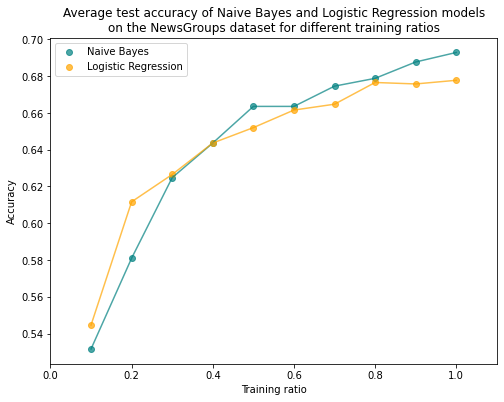

In [ ]:
# Plot average validation accuracies NewsGroups
plt.plot()
plt.scatter(qValues, testAccuraciesNB1,label='Naive Bayes',c='teal',alpha=0.7)
plt.plot(qValues, testAccuraciesNB1,'teal',alpha=0.7)
plt.scatter(qValues, testAccuraciesLR1,label='Logistic Regression',c='orange',alpha=0.7)
plt.plot(qValues, testAccuraciesLR1,'orange',alpha=0.7)
plt.title('Average test accuracy of Naive Bayes and Logistic Regression models\non the NewsGroups dataset for different training ratios')
plt.xlabel('Training ratio')
plt.ylabel('Accuracy')
plt.xlim(0,max(qValues)+0.1)
plt.legend()
plt.show()

In [ ]:
# Sentiment NB
model_name = MultinomialNaiveBayes
hyperparameters = [optParameterNB2]
testAccuraciesNB2 = modelAccuracy(Sentiment140,K,model_name,hyperparameters,qValues)



Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.90257813 0.90414063 0.9078125  0.90140625 0.90171875] 
	Valid Accuracy:  [0.7153125 0.7234375 0.7125    0.7284375 0.7365625]
Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.87796875 0.88113281 0.87941406 0.87957031 0.87796875] 
	Valid Accuracy:  [0.72984375 0.73671875 0.74328125 0.7396875  0.7240625 ]
Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.87164397 0.87268561 0.87107107 0.87484701 0.86976902] 
	Valid Accuracy:  [0.73729167 0.7409375  0.7503125  0.73489583 0.74270833]
Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.86177734 0.86441406 0.86306641 0.86314453 0.86470703] 
	Valid Accuracy:  [0.74773437 0.7459375  0.73898438 0.73617188 0.73960938]
Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.8600625  0.859125   0.85971875 0.86026563 0.8605625 ] 
	Valid Accuracy:  [0.740625  0.749875  0.7445    0.7425    0.7420625]
Hyperparameter: {'alpha': 2}
	Train Accuracy:  [0.85549479 0.85558594 0.85502604 0.85463542 0.85402344] 
	Vali

In [ ]:
# Sentiment LR
model_name = LogisticRegression
hyperparameters = [optParameterLR2]
testAccuraciesLR2 = modelAccuracy(Sentiment140,K,model_name,hyperparameters,qValues)

Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
	Train Accuracy:  [0.91710938 0.91703125 0.9178125  0.91578125 0.9184375 ] 
	Valid Accuracy:  [0.746875  0.7315625 0.7375    0.745     0.7315625]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


	Train Accuracy:  [0.89699219 0.89691406 0.89859375 0.89632813 0.89738281] 
	Valid Accuracy:  [0.7428125  0.74234375 0.743125   0.746875   0.74125   ]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


	Train Accuracy:  [0.88896122 0.88804979 0.89054973 0.89018515 0.89041952] 
	Valid Accuracy:  [0.74666667 0.75072917 0.7584375  0.74708333 0.75041667]
Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.88025391 0.88148437 0.88244141 0.88035156 0.88003906] 
	Valid Accuracy:  [0.75664062 0.75296875 0.75101562 0.75445312 0.756875  ]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.874125   0.8741875  0.87539062 0.87467187 0.87339062] 
	Valid Accuracy:  [0.758     0.7561875 0.7505625 0.757375  0.7530625]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.871875   0.87104167 0.87173177 0.87157552 0.87029948] 
	Valid Accuracy:  [0.76234375 0.75609375 0.76260417 0.75677083 0.75895833]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.86904164 0.86711086 0.87000145 0.86877379 0.86738987] 
	Valid Accuracy:  [0.75941964 0.7646875  0.75584821 0.75933036 0.7665625 ]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.86547852 0.86613281 0.86631836 0.86765625 0.86476562] 
	Valid Accuracy:  [0.76183594 0.76644531 0.75613281 0.76589844 0.76183594]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.86322049 0.86168403 0.86414062 0.86386285 0.86307292] 
	Valid Accuracy:  [0.76246528 0.76423611 0.76208333 0.76024306 0.75958333]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Hyperparameter: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


	Train Accuracy:  [0.8623125  0.86079688 0.86235938 0.8626875  0.85883594] 
	Valid Accuracy:  [0.7634375  0.76609375 0.7663125  0.761625   0.76490625]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


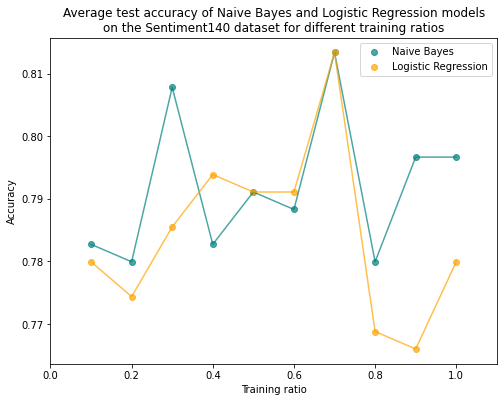

In [ ]:
# Plot average validation accuracies Sentiment 140
plt.plot()
plt.scatter(qValues, testAccuraciesNB2,label='Naive Bayes',c='teal',alpha=0.7)
plt.plot(qValues, testAccuraciesNB2,'teal',alpha=0.7)
plt.scatter(qValues, testAccuraciesLR2,label='Logistic Regression',c='orange',alpha=0.7)
plt.plot(qValues, testAccuraciesLR2,'orange',alpha=0.7)
plt.title('Average test accuracy of Naive Bayes and Logistic Regression models\non the Sentiment140 dataset for different training ratios')
plt.xlabel('Training ratio')
plt.ylabel('Accuracy')
plt.xlim(0,max(qValues)+0.1)
plt.legend()
plt.show()

### 3.4 Experiments

We explore the predictive strength of Multinomial Naive Bayes on the NewsGroups dataset. 



In [108]:
# Want rank of y index in each row
x = np.array([[0.3,0.4,0.2,0.1], 
              [0.1,0.4,0.2,0.3],
              [0.5,0.1,0.05,0.15]])
y = np.array([2,1,3]) 
order = np.argsort(-x,axis=1)
orderr = np.argsort(order,axis=1)
print(order)
print(orderr)
print(orderr[np.arange(x.shape[0]),y])
# WANT 1, 3

[[1 0 2 3]
 [1 3 2 0]
 [0 3 1 2]]
[[1 0 2 3]
 [3 0 2 1]
 [0 2 3 1]]
[2 0 1]


In [109]:

# Predict class labels from data, add predictive strength
def predictRank(self, x, y):
  Nt, D = x.shape 
  # Prior:  Concatenate pi Nt times --> [C x Nt] matrix
  log_prior = sparse.csr_matrix(np.repeat(np.log(self.pi)[:,np.newaxis], Nt, 1))
  # Likelihood: log(theta) * transpose(X): [C x D] * [D x Nt] = [C x Nt]
  log_likelihood = sparse.csr_matrix(np.log(self.theta)) * x.transpose()
  log_posterior = (log_prior + log_likelihood).toarray() # Posterior = prior + likelihood
  posterior = np.exp(log_posterior - logsumexp(log_posterior)) # Normalize 
  y_prob = posterior.T
  y_pred = np.argmax(y_prob,1)

  order = np.argsort(-y_prob,axis=1)
  orders = np.argsort(order,axis=1)
  ranks = orders[np.arange(y_prob.shape[0]),y]

  return y_pred, ranks

MultinomialNaiveBayes.predictRank = predictRank




In [110]:
# Train MNB on Newsgroups
NBrank = MultinomialNaiveBayes(**optParameterNB1)    
NBrank.fit(newsgroups_trainData,newsgroups_trainLabels)   

# Predict test labels using validation set, record validation accuracy
y_pred, ranks = NBrank.predictRank(newsgroups_testData, newsgroups_testLabels)




We now plot the rank distribution. This is clearly an exponential distribution. The MLE for the $\lambda$ parameter is given by 
$$\hat{\lambda} = \frac{n}{\sum_{i=1}^N x_i}$$

In [164]:
bins = np.bincount(ranks)
print(bins)

top5 = bins[0]+bins[1]+bins[2]+bins[3]+bins[4]
total = bins.sum()
top5/total

[5219  831  398  225  144  125  115   60   68   56   52   38   38   23
   31   24   30   28   15   12]


0.9050716941051513

(0.0, 1.2748274030801912)
0.6153145991551003


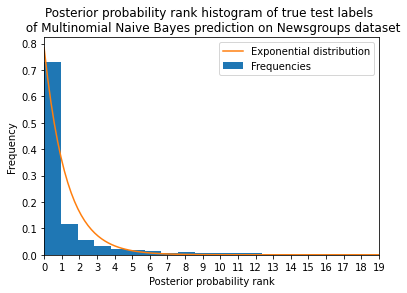

In [162]:
import scipy.stats as ss

# Find MLE for exponential distribution
MLE = ss.expon.fit(ranks)
print(MLE)
Lambda_MLE = MLE[1]
variance = 1/(Lambda_MLE**2)
print(variance)

# Exponential distribution
expX = np.linspace(0,19,100)
expY = ss.expon.pdf(expX, *MLE)

#need to plot the normalized histogram with `normed=True`
plt.hist(ranks,bins=20,density=True,label='Frequencies')
plt.plot(expX, expY,label='Exponential distribution')
plt.title('Posterior probability rank histogram of true test labels \n of Multinomial Naive Bayes prediction on Newsgroups dataset')
plt.xlabel('Posterior probability rank')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.xlim(0,19,1)
plt.show()




9602


[my last braincell](https://upload.wikimedia.org/wikipedia/commons/3/37/Theodore_Kaczynski.jpg)